In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

from torchvision import transforms

%matplotlib inline

In [2]:
env = gym.make("Pong-v0")

[2018-01-04 18:40:47,390] Making new env: Pong-v0


In [3]:
downsample = 4

def preprocess(frame):
    '''from karpathy.'''
    I = frame
    I = I[35:195] # crop
    I = I[::downsample,::downsample,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    tensor = torch.from_numpy(I).float()
    return tensor.unsqueeze(0).unsqueeze(0) #BCHW

def clip_grads(net, low=-10, high=10):
    """Gradient clipping to the range [low, high]."""
    parameters = [param for param in net.parameters()
                  if param.grad is not None]
    for p in parameters:
        p.grad.data.clamp_(low, high)
        
if torch.cuda.is_available():
    def to_var(x, requires_grad=False, gpu=None):
        x = x.cuda(gpu)
        return Variable(x, requires_grad=requires_grad)
else:
    def to_var(x, requires_grad=False, vgpu=None):
        return Variable(x, requires_grad=requires_grad)

In [4]:
class Net(nn.Module):
    def __init__(self, action_n):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(1,32,kernel_size=5),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
                                  nn.Conv2d(32,128,kernel_size=5),nn.ReLU(),nn.MaxPool2d(kernel_size=2),
                                  nn.Conv2d(128,32,kernel_size=5),nn.ReLU(),nn.AdaptiveMaxPool2d(output_size=1))
        self.fc = nn.Linear(32, action_n)
        
    def forward(self, x):
        feat = self.conv(x)
        logit = self.fc(feat.view(feat.size(0),-1))
        return logit

In [5]:
class PolicyGradient:
    
    def __init__(self, model, gamma=0.99, eps=1.e-6, running_gamma=0.99, running_start=0,
#                 episode2thresh=lambda i: 0.05+0.9*np.exp(-1. * i / 100) if i>150 else 0): # eploration will start after 150 episodes
                 episode2thresh=lambda i: 0): # without exploration
        self.model = model
        self.gamma = gamma
        self.eps = eps
        self.log_probs = []
        self.rewards = []
        self.total_rewards = []
        self.running_reward = running_start
        self.running_gamma = running_gamma
        self.episode2thresh = episode2thresh
        
    @property
    def episodes(self):
        return len(self.total_rewards)
        
    def select_action(self,obs):
        self.model.train()
        thresh=self.episode2thresh(self.episodes)
        action, log_prob = select_action(obs, self.model, thresh=thresh)
        self.log_probs.append(log_prob)
        return action
    
    def get_loss_and_clear(self):
        total_reward = sum(self.rewards)
        self.total_rewards.append(total_reward)
        self.running_reward = self.running_gamma*self.running_reward+(1-self.running_gamma)*total_reward
        policy_loss = get_policy_loss(self.log_probs, self.rewards, self.gamma, self.eps)
        del self.log_probs[:]
        del self.rewards[:]
        return policy_loss
    
    def take_action(self, action, env, render=False):
        obs, reward, done, info = env.step(action)
        self.rewards.append(reward)
        if render:
            env.render()
        return obs, reward, done, info
    
    def greedy_policy(self, obs):
        self.model.eval()
        state = to_var(obs)
        prob = self.model(state)
        _, action = prob.max(dim=1)
        return action.data[0]

def select_action(obs, model, thresh=0):
    state = to_var(obs)
    logits = model(state)
    probs = F.softmax(logits, dim=1)
    m = Categorical(probs)
    if np.random.random()>thresh:
#         print(probs)
        try:
            action = m.sample()
        except:
            print(probs,m)
            raise
    else:
        action_space = probs.size(1)
        action = to_var(torch.from_numpy(np.random.randint(action_space,size=1)))
    return action.data[0],m.log_prob(action)
    
def get_normalized_rewards(rewards, gamma, eps):
    acc = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        acc.append(R)
    ret = to_var(torch.Tensor(acc[::-1]),requires_grad=False)
    ret = (ret - ret.mean()) / (ret.std()+eps)
#     print(ret)
    return ret

def get_policy_loss(log_probs,rewards, gamma,eps):
    log_probs_v = torch.cat(log_probs)
    rewards_v = get_normalized_rewards(rewards, gamma, eps)
    return -log_probs_v.dot(rewards_v)

In [6]:
net = Net(env.action_space.n)
if torch.cuda.is_available():
    net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr=1.e-4,weight_decay=0.001)
trainer = PolicyGradient(model=net,running_start=-21)
writer = SummaryWriter()

In [7]:
import os

writer_path = list(writer.all_writers.keys())[0]
weight_join = lambda p: os.path.join(writer_path, p)

In [8]:
for episode in trange(100000):
    frame = env.reset()
    last_obs = preprocess(frame)
    curr_obs = preprocess(frame)
    total_reward = 0
    for step in range(100000): # not exceed 10000 steps
        action = trainer.select_action(obs=curr_obs-last_obs)
        frame, reward, done, _ = trainer.take_action(action, env, render=False)
        last_obs = curr_obs
        curr_obs = preprocess(frame)
        total_reward+=reward
        if done:
             break
    if step==100000:
        print("not enough!!!!!!!!!!!!!!!")
    policy_loss = trainer.get_loss_and_clear()
    writer.add_scalar("loss",policy_loss.data[0],episode)
    writer.add_scalar("reward",total_reward,episode)
#     print(policy_loss)
    optimizer.zero_grad()
    policy_loss.backward()
    clip_grads(trainer.model,-5,5)
    optimizer.step()
    running_reward = trainer.running_reward
    if episode%100==0:
        print(episode, total_reward,running_reward)
        torch.save(net.state_dict(), weight_join("episode%s.pth"%episode))
    if running_reward>1:
        break
print("Finished: %s@%s" %(trainer.running_reward,episode))

  0%|          | 1/100000 [00:03<104:12:13,  3.75s/it]

0 -21.0 -21.0


  0%|          | 101/100000 [04:39<74:23:24,  2.68s/it]

100 -19.0 -20.64421028941644


  0%|          | 201/100000 [09:15<82:25:59,  2.97s/it]

200 -20.0 -20.360638255091786


  0%|          | 301/100000 [13:50<74:17:44,  2.68s/it]

300 -21.0 -20.329039091860324


  0%|          | 401/100000 [18:30<77:42:06,  2.81s/it]

400 -20.0 -20.229167014360023


  1%|          | 501/100000 [23:15<73:49:53,  2.67s/it]

500 -21.0 -20.209544466054908


  1%|          | 601/100000 [27:55<76:19:46,  2.76s/it]

600 -21.0 -20.299580858309174


  1%|          | 701/100000 [32:34<76:35:24,  2.78s/it]

700 -21.0 -20.24288395873034


  1%|          | 801/100000 [37:47<88:07:34,  3.20s/it]

800 -20.0 -20.095226916628455


  1%|          | 901/100000 [43:22<98:49:42,  3.59s/it]

900 -21.0 -20.15429695432163


  1%|          | 1001/100000 [49:11<102:09:38,  3.71s/it]

1000 -20.0 -20.055452488311484


  1%|          | 1101/100000 [55:07<100:43:03,  3.67s/it]

1100 -21.0 -20.087532455230704


  1%|          | 1201/100000 [1:01:16<94:18:23,  3.44s/it] 

1200 -20.0 -19.887916520024426


  1%|▏         | 1301/100000 [1:07:18<94:06:51,  3.43s/it]

1300 -20.0 -19.97323076455893


  1%|▏         | 1401/100000 [1:13:26<118:07:44,  4.31s/it]

1400 -17.0 -19.894025298086355


  2%|▏         | 1501/100000 [1:19:41<100:58:36,  3.69s/it]

1500 -20.0 -19.820310232929216


  2%|▏         | 1601/100000 [1:26:07<102:19:08,  3.74s/it]

1600 -21.0 -19.797815108062373


  2%|▏         | 1701/100000 [1:32:25<110:00:58,  4.03s/it]

1700 -19.0 -19.783183258905975


  2%|▏         | 1801/100000 [1:38:51<102:56:00,  3.77s/it]

1800 -19.0 -19.686674809403815


  2%|▏         | 1901/100000 [1:45:21<108:03:29,  3.97s/it]

1900 -20.0 -19.710331649036092


  2%|▏         | 2001/100000 [1:51:51<98:38:51,  3.62s/it] 

2000 -20.0 -19.57568244976041


  2%|▏         | 2101/100000 [1:58:17<104:00:24,  3.82s/it]

2100 -19.0 -19.582660230119235


  2%|▏         | 2201/100000 [2:04:52<104:47:15,  3.86s/it]

2200 -20.0 -19.585533227135816


  2%|▏         | 2301/100000 [2:11:23<99:56:43,  3.68s/it] 

2300 -21.0 -19.57397041350676


  2%|▏         | 2401/100000 [2:18:04<113:21:16,  4.18s/it]

2400 -18.0 -19.614141845664264


  3%|▎         | 2501/100000 [2:24:37<106:41:27,  3.94s/it]

2500 -19.0 -19.791375929667623


  3%|▎         | 2601/100000 [2:31:28<111:55:51,  4.14s/it]

2600 -19.0 -19.483563982980566


  3%|▎         | 2701/100000 [2:38:18<117:55:02,  4.36s/it]

2700 -16.0 -19.413731199205085


  3%|▎         | 2801/100000 [2:45:14<109:49:11,  4.07s/it]

2800 -19.0 -19.447162395406085


  3%|▎         | 2901/100000 [2:51:53<117:59:18,  4.37s/it]

2900 -17.0 -19.416020414818856


  3%|▎         | 3001/100000 [2:58:40<106:14:00,  3.94s/it]

3000 -19.0 -19.498610956855075


  3%|▎         | 3101/100000 [3:05:04<101:13:46,  3.76s/it]

3100 -18.0 -19.53420347075769


  3%|▎         | 3201/100000 [3:11:43<114:13:11,  4.25s/it]

3200 -17.0 -19.500970998408818


  3%|▎         | 3301/100000 [3:18:48<122:21:40,  4.56s/it]

3300 -17.0 -19.466383077412914


  3%|▎         | 3401/100000 [3:25:47<108:12:50,  4.03s/it]

3400 -20.0 -19.530707574161763


  4%|▎         | 3501/100000 [3:32:58<124:48:17,  4.66s/it]

3500 -19.0 -19.518967309549897


  4%|▎         | 3601/100000 [3:39:15<96:16:17,  3.60s/it]

3600 -18.0 -19.462957554877413


  4%|▎         | 3701/100000 [3:45:19<97:38:19,  3.65s/it]

3700 -17.0 -19.32231810774864


  4%|▍         | 3801/100000 [3:51:59<89:48:49,  3.36s/it]

3800 -21.0 -19.202326125132586


  4%|▍         | 3901/100000 [3:57:50<89:18:28,  3.35s/it]

3900 -20.0 -19.341351432471335


  4%|▍         | 4001/100000 [4:03:42<95:39:46,  3.59s/it]

4000 -16.0 -19.255333106646457


  4%|▍         | 4101/100000 [4:09:31<87:24:46,  3.28s/it]

4100 -20.0 -19.236928888868004


  4%|▍         | 4201/100000 [4:15:30<101:10:58,  3.80s/it]

4200 -20.0 -19.288324727462207


  4%|▍         | 4301/100000 [4:21:40<99:08:34,  3.73s/it]

4300 -20.0 -19.3462457362299


  4%|▍         | 4401/100000 [4:28:02<104:52:14,  3.95s/it]

4400 -20.0 -19.258637301992295


  5%|▍         | 4501/100000 [4:34:28<110:08:54,  4.15s/it]

4500 -16.0 -19.2757161731462


KeyboardInterrupt: 

# stopped! seems not promising...

In [9]:
torch.save(net.state_dict(), weight_join("final.pth"))

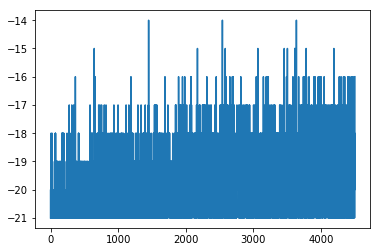

In [10]:
plt.plot(trainer.total_rewards)

In [11]:
writer_path

'runs/Jan04_18-40-50_amax'